In [2]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2023-03-20 17:53:35--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/si11cws2pyho1bp/archive.zip [following]
--2023-03-20 17:53:36--  https://www.dropbox.com/s/raw/si11cws2pyho1bp/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc40f00cc704a9d8f5dca7eef407.dl.dropboxusercontent.com/cd/0/inline/B4kXYVTL5oG9xIXzOJky-jA0_vU231uEQq9flnRLlxfxa-b5bOcNcGx07pyi40_jgkXdBjiEwJY8Q5wI3ga9PJcq0zRQ3E_JjprlZn4sMCHWNWApgDs9Uu9A4TexPJbMOtmxXD_a9mmEsLk60rDEubq1HpgfUJIJGuIDD7BWbmh9lg/file# [following]
--2023-03-20 17:53:36--  https://uc40f00cc704a9d8f5dca7eef407.dl.dropboxusercontent.com/cd/0/inline/B4kXYVTL5oG9xIXzOJky-jA0_vU231uEQq9flnRLlxfxa-b5bOcNcGx07pyi40_jgkXdBjiEwJY8Q5wI

In [3]:
!unzip -q "/content/archive.zip"

In [4]:
# lets import required modules

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
# Creating the Pathlib PATH objects for train and test dataset paths

train_path = Path("/content/train")
test_path = Path("/content/test")

In [6]:
# Getting Image paths 

train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/content/train/angry/Training_35386854.jpg',
 '/content/train/angry/Training_94377760.jpg',
 '/content/train/angry/Training_80965033.jpg',
 '/content/train/angry/Training_27165790.jpg',
 '/content/train/angry/Training_14641612.jpg',
 '/content/train/angry/Training_71385343.jpg',
 '/content/train/angry/Training_88076124.jpg',
 '/content/train/angry/Training_70731802.jpg',
 '/content/train/angry/Training_803556.jpg',
 '/content/train/angry/Training_66118663.jpg']

In [45]:
len(train_image_paths)

28709

In [7]:
# Getting their respective labels 

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry']

In [8]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [10]:
from sklearn.model_selection import train_test_split 

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , train_size = 0.80)

In [11]:

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8091507, 1: 16.036112, 2: 1.7812403, 3: 1.0, 4: 1.4414482, 5: 1.4840617, 6: 2.3027523}


In [12]:
def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [13]:
IMG_SIZE = 96 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [15]:
train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(32, 96, 96, 3)
(32, 7)


sad


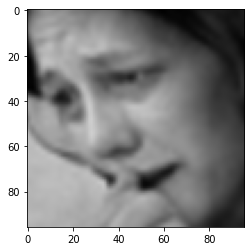

In [16]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [17]:
# Lets apply same steps on validation data

val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


neutral


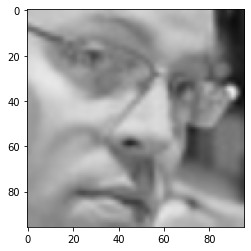

In [18]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [19]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31790344/31790344 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 7,882,249
Non

In [20]:
from tensorflow.keras.applications import EfficientNetB2

model = tf.keras.Sequential([
    EfficientNetB2(input_shape=(96, 96, 3),include_top=False),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1408)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               180352    
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 7,882,249
Non-trainable params: 67,575
_______________________________________

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [23]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
717/717 [==============================] - 164s 142ms/step - loss: 2.7893 - accuracy: 0.3938 - precision: 0.6483 - recall: 0.1834 - val_loss: 1.2828 - val_accuracy: 0.5091 - val_precision: 0.7346 - val_recall: 0.3305
Epoch 2/8
717/717 [==============================] - 100s 139ms/step - loss: 2.3527 - accuracy: 0.4924 - precision: 0.6885 - recall: 0.2874 - val_loss: 1.2273 - val_accuracy: 0.5337 - val_precision: 0.7014 - val_recall: 0.3593
Epoch 3/8
717/717 [==============================] - 99s 138ms/step - loss: 2.1887 - accuracy: 0.5252 - precision: 0.7007 - recall: 0.3358 - val_loss: 1.1442 - val_accuracy: 0.5637 - val_precision: 0.7128 - val_recall: 0.4056
Epoch 4/8
717/717 [==============================] - 100s 139ms/step - loss: 2.0815 - accuracy: 0.5474 - precision: 0.7101 - recall: 0.3599 - val_loss: 1.2127 - val_accuracy: 0.5478 - val_precision: 0.6837 - val_recall: 0.3996
Epoch 5/8
717/717 [==============================] - 100s 139ms/step - loss: 1.9984 - accurac

In [25]:
model.layers[0].trainable = False

In [26]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1408)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               180352    
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 181,255
Non-trainable params: 7,768,569
______________________________________

In [28]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
717/717 [==============================] - ETA: 0s - loss: 1.7121 - accuracy: 0.6182 - precision: 0.7473 - recall: 0.4783
Epoch 1: val_loss improved from inf to 1.17575, saving model to best_weights.h5
717/717 [==============================] - 99s 137ms/step - loss: 1.7121 - accuracy: 0.6182 - precision: 0.7473 - recall: 0.4783 - val_loss: 1.1757 - val_accuracy: 0.5660 - val_precision: 0.6587 - val_recall: 0.4681
Epoch 2/8
717/717 [==============================] - ETA: 0s - loss: 1.6934 - accuracy: 0.6193 - precision: 0.7417 - recall: 0.4778
Epoch 2: val_loss improved from 1.17575 to 1.11596, saving model to best_weights.h5
717/717 [==============================] - 99s 138ms/step - loss: 1.6934 - accuracy: 0.6193 - precision: 0.7417 - recall: 0.4778 - val_loss: 1.1160 - val_accuracy: 0.5838 - val_precision: 0.7017 - val_recall: 0.4583
Epoch 3/8
717/717 [==============================] - ETA: 0s - loss: 1.6872 - accuracy: 0.6246 - precision: 0.7499 - recall: 0.4824
Epoch 3:

In [29]:
# Lets create Tesing dataset just like how we did for Training dataset

test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)


In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_test_dataset(paths , labels ):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [31]:
test_dataset = get_test_dataset(test_image_paths, test_labels)

In [32]:
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


angry


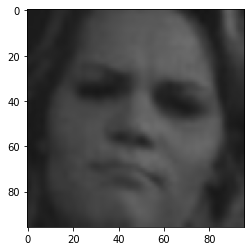

In [33]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [34]:
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

225/225 [==============================] - 10s 44ms/step - loss: 1.0797 - accuracy: 0.6073 - precision: 0.6839 - recall: 0.5274
 Testing Acc :  0.607272207736969
 Testing Precision  0.6838873028755188
 Testing Recall  0.5274449586868286


In [ ]:
# Save Model
model.save("FacialExpressionModel.h5")

In [36]:
# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()